# How to create map-reduce branches for parallel execution

A common pattern in agents is to generate a list of objects, do some work on each of those objects, and then combine the results. This is very similar to the common [map-reduce](https://en.wikipedia.org/wiki/MapReduce) operation. This can be tricky for a few reasons. First, it can be tough to define a structured graph ahead of time because the length of the list of objects may be unknown. Second, in order to do this map-reduce you need multiple versions of the state to exist... but the graph shares a common shared state, so how can this be?

LangGraph supports this via the `Send` api. This can be used to allow a conditional edge to `Send` multiple different states to multiple nodes. The state it sends can be different from the state of the core graph.

Let's see what this looks like in action! We'll put together a toy example of generating a list of words, and then writing a joke about each word, and then judging what the best joke is.

In [ ]:
%pip install -U langchain-anthropic langgraph

In [1]:
import os
import getpass


def _set_env(name: str):
    if not os.getenv(name):
        os.environ[name] = getpass.getpass(f"{name}: ")


_set_env("ANTHROPIC_API_KEY")

In [2]:
import operator
from typing import Annotated, TypedDict

from langchain_core.pydantic_v1 import BaseModel
from langchain_anthropic import ChatAnthropic

from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START

# Model and prompts
# Define model and prompts we will use
subjects_prompt = """Generate a comma separated list of between 2 and 5 {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.

{jokes}"""


class Subjects(BaseModel):
    subjects: list[str]


class Joke(BaseModel):
    joke: str


class BestJoke(BaseModel):
    id: int


model = ChatAnthropic(model="claude-3-5-sonnet-20240620")

# Graph components: define the components that will make up the graph


# This will be the overall state of the main graph.
# It will contain a topic (which we expect the user to provide)
# and then will generate a list of subjects, and then a joke for
# each subject
class OverallState(TypedDict):
    topic: str
    subjects: list
    # Notice here we use the operator.add
    # This is because we want combine all the jokes we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    jokes: Annotated[list, operator.add]
    best_selected_joke: str


# This will be the state of the node that we will "map" all
# subjects to in order to generate a joke
class JokeState(TypedDict):
    subject: str


# This is the function we will use to generate the subjects of the jokes
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


# Here we generate a joke, given a subject
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


# Here we define the logic to map out over the generated subjects
# We will use this an edge in the graph
def continue_to_jokes(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


# Here we will judge the best joke
def best_joke(state: OverallState):
    jokes = "\n\n".format()
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}


# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)
app = graph.compile()

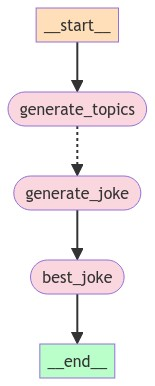

In [3]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [4]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['lion', 'elephant', 'penguin', 'giraffe']}}
{'generate_joke': {'jokes': ["Why don't you see penguins in Britain? Because they're afraid of Wales!"]}}
{'generate_joke': {'jokes': ["Why don't elephants use computers? They're afraid of the mouse!"]}}
{'generate_joke': {'jokes': ["Why don't lions like fast food? Because they can't catch it!"]}}
{'generate_joke': {'jokes': ["Why don't giraffes ever get caught in traffic jams? Because they can always stick their necks out and see what's ahead!"]}}
{'best_joke': {'best_selected_joke': "Why don't elephants use computers? They're afraid of the mouse!"}}
